In [51]:
import datetime
import gc
import joblib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import optuna
import os
import scipy.stats
import seaborn as sns
import sys
sys.path.append("../")
import time
import warnings
warnings.simplefilter("ignore")
from itertools import repeat
from lightgbm import LGBMClassifier, log_evaluation
from sklearn.calibration import CalibrationDisplay
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, fbeta_score, make_scorer
from tqdm import tqdm

In [52]:
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import ListedColormap
from cycler import cycler
from IPython.display import display
from colorama import Fore, Back, Style
plt.rcParams['axes.facecolor'] = '#0057b8' # blue
plt.rcParams['axes.prop_cycle'] = cycler(color=['#ffd700'] +
                                         plt.rcParams['axes.prop_cycle'].by_key()['color'][1:])
plt.rcParams['text.color'] = 'w'

In [53]:
from utils.common import (
    sigmoid, pad_column_name
)
from utils.constants import (
    RAW_DATA_PATH, PROCESSED_DATA_PATH
)
from utils.eval_helpers import (
    plot_roc_curves, plot_feature_importance, 
    amex_metric, get_final_metric_df, amex_metric_np, lgb_amex_metric
)
from utils.eda_helpers import (
    plot_missing_proportion_barchart, 
    get_cols
)
from utils.extraction_helpers import read_file
from utils.feature_group import (
    CATEGORY_COLUMNS, CONTINUOUS_COLUMNS, NON_FEATURE_COLUMNS,
    MEAN_FEATURES, MIN_FEATURES, MAX_FEATURES, LAST_FEATURES, FIRST_FEATURES,
    RANGE_FEATURES, VELOCITY_FEATURES, SPEED_FEATURES
)
from utils.feature_engineering_helpers import process_data

In [76]:
RAW_DATA_PATH = "../raw_data"
PROCESSED_DATA_PATH = "../processed_data"
SUBMISSION_DATA_PATH = "../submissions"
EVALUATION_DATA_PATH = "../evaluation_data"
MODELS_PATH = "../models"
EXP_PATH = "../experiments"
DROP_FEATURES_PATH = "../dropped_features"

In [55]:
%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Read Data

In [6]:
%%time
# train = read_file(f"{RAW_TRAIN_PICKLE_PATH}/train_data.pkl")
# test = read_file(f"{RAW_TEST_PICKLE_PATH}/test_data.pkl")

CPU times: user 6 µs, sys: 2 µs, total: 8 µs
Wall time: 13.8 µs


In [7]:
%%time
train_agg = read_file(f"{PROCESSED_DATA_PATH}/train_agg.pkl")
# test = read_file(f"{PROCESSED_DATA_PATH}/test_data_imputed.pkl")

Shape of data: (458913, 2161)
CPU times: user 1.25 s, sys: 5.47 s, total: 6.71 s
Wall time: 9.41 s


In [8]:
# train_missing_prop_df = plot_missing_proportion_barchart(train, top_n=50)

In [9]:
# train_missing_prop_df = plot_missing_proportion_barchart(train, top_n=40)

In [10]:
# train_analysis = single_col_target_check(train, "R_13", q=10)

In [11]:
# train_agg_analysis = single_col_target_check(train_agg, "S_6_last", q=10)

In [12]:
# train_agg_analysis.head()

In [13]:
# selected_features = pd.read_csv("top_features.csv")
# selected_features = selected_features["feature"].tolist()

In [14]:
# selected_features = (
#     [c + "_avg" for c in MEAN_FEATURES] +
#     [c + "_min" for c in MIN_FEATURES] +
#     [c + "_max" for c in MAX_FEATURES] +
#     # [c + "_first" for c in FIRST_FEATURES] +
#     [c + "_last" for c in LAST_FEATURES] +
#     [c + "_range" for c in RANGE_FEATURES] +
#     [c + "_velocity" for c in VELOCITY_FEATURES] +
#     [c + "_speed" for c in SPEED_FEATURES] +
#     [c for c in train_agg.columns if c.endswith(("_previous", "_lag1_diff", "_last_lift"))]
# )

In [15]:
# train_agg = train_agg.loc[:, selected_features]

In [16]:
train_agg.shape

(458913, 2161)

In [17]:
target = train_agg["target"].values

In [18]:
%%time
train_agg = train_agg.drop(columns=NON_FEATURE_COLUMNS, errors="ignore")

CPU times: user 181 ms, sys: 406 ms, total: 587 ms
Wall time: 584 ms


In [19]:
train_agg.shape

(458913, 2159)

In [20]:
# missing_count_df = plot_missing_proportion_barchart(train_agg)

In [21]:
# high_missing_columns = missing_count_df.loc[missing_count_df["missing_proportion"] > 75, "column"].tolist()

In [22]:
# print("Pre feature drop", train.shape)
# train_agg = train_agg.loc[:, set(feature_list).intersection(set(train_agg.columns))]
# train_agg = train_agg.drop(columns=high_missing_columns, errors="ignore")
# print("Post feature drop", train.shape)

### Oversampling / Undersampling (SMOTE)

In [23]:
# from imblearn.over_sampling import SMOTE
# sm = SMOTE(random_state=923)
# X_res, y_res = sm.fit_resample(train.loc[:, num_features], 
#                                train["target"])
# X_res.shape, y_res.shape

### Train Single LGBM

In [24]:
kf = StratifiedKFold(n_splits=5)

In [42]:
params = {
    'categorical_feature': 'auto',
    'random_state': 1,
    'reg_alpha': 0.02, #0.0125, 
    'reg_lambda': 30, 
    'learning_rate': 0.02, 
    'n_estimators': 2000, 
    'colsample_bytree': 0.17, 
    'subsample': 0.7, 
    'subsample_freq': 5, 
    'min_child_samples': 2400, 
    'scale_pos_weight': , 
    'max_bins': 460, 
    'num_leaves': 100
}

In [43]:
n_est_list = repeat(2000)

In [44]:
val_idx_list, train_score_list, val_score_list = [], [], []
for fold, (idx_tr, idx_va), n_est in zip(range(1, 5+1), kf.split(train_agg, target), n_est_list):
    X_train, X_val, y_train, y_val, model = None, None, None, None, None
    X_train = train_agg.iloc[idx_tr]
    X_val = train_agg.iloc[idx_va]
    y_train = target[idx_tr]
    y_val = target[idx_va]
    params["n_estimators"] = n_est
    model = LGBMClassifier(**params)
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore', category=UserWarning)
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_val, y_val)], 
            eval_metric=[lgb_amex_metric],
            callbacks=[log_evaluation(200)]
        )
    y_train_pred = model.predict_proba(X_train, raw_score=True)
    train_score, train_g, train_t4 = amex_metric(y_train, y_train_pred)
    X_train, y_train = None, None
    y_val_pred = model.predict_proba(X_val, raw_score=True)
    val_score, val_g, val_t4 = amex_metric(y_val, y_val_pred)
    print(f"{Fore.BLUE}{Style.BRIGHT}Fold {fold} | Train Score = {train_score:.5f} ({train_g:.4f}, {train_t4:.4f})")
    print(f"{Fore.GREEN}{Style.BRIGHT}Fold {fold} | Val Score = {val_score:.5f} ({val_g:.4f}, {val_t4:.4f}){Style.RESET_ALL}")
    joblib.dump(model, f'{EXP_PATH}/lgbm_gbdt_exp2/models/model{fold}.pkl')
    val_idx_list.append(idx_va)
    train_score_list.append(train_score)
    val_score_list.append(val_score)

[200]	valid_0's binary_logloss: 0.321932	valid_0's amex: 0.768127
[400]	valid_0's binary_logloss: 0.306865	valid_0's amex: 0.784405
[600]	valid_0's binary_logloss: 0.298095	valid_0's amex: 0.789534
[800]	valid_0's binary_logloss: 0.292465	valid_0's amex: 0.791759
[1000]	valid_0's binary_logloss: 0.287879	valid_0's amex: 0.793436
[1200]	valid_0's binary_logloss: 0.283857	valid_0's amex: 0.7938
[1400]	valid_0's binary_logloss: 0.28035	valid_0's amex: 0.79388
[1600]	valid_0's binary_logloss: 0.277327	valid_0's amex: 0.793645
[1800]	valid_0's binary_logloss: 0.274412	valid_0's amex: 0.794292
[2000]	valid_0's binary_logloss: 0.271772	valid_0's amex: 0.793747
Fold 1 | Train Score = 0.88200 (0.9679, 0.7961)
Fold 1 | Val Score = 0.79357 (0.9231, 0.6641)
[200]	valid_0's binary_logloss: 0.321659	valid_0's amex: 0.765484
[400]	valid_0's binary_logloss: 0.307241	valid_0's amex: 0.783637
[600]	valid_0's binary_logloss: 0.299096	valid_0's amex: 0.788031
[800]	valid_0's binary_logloss: 0.293839	valid

In [45]:
np.mean(val_score_list)

0.7948689425109867

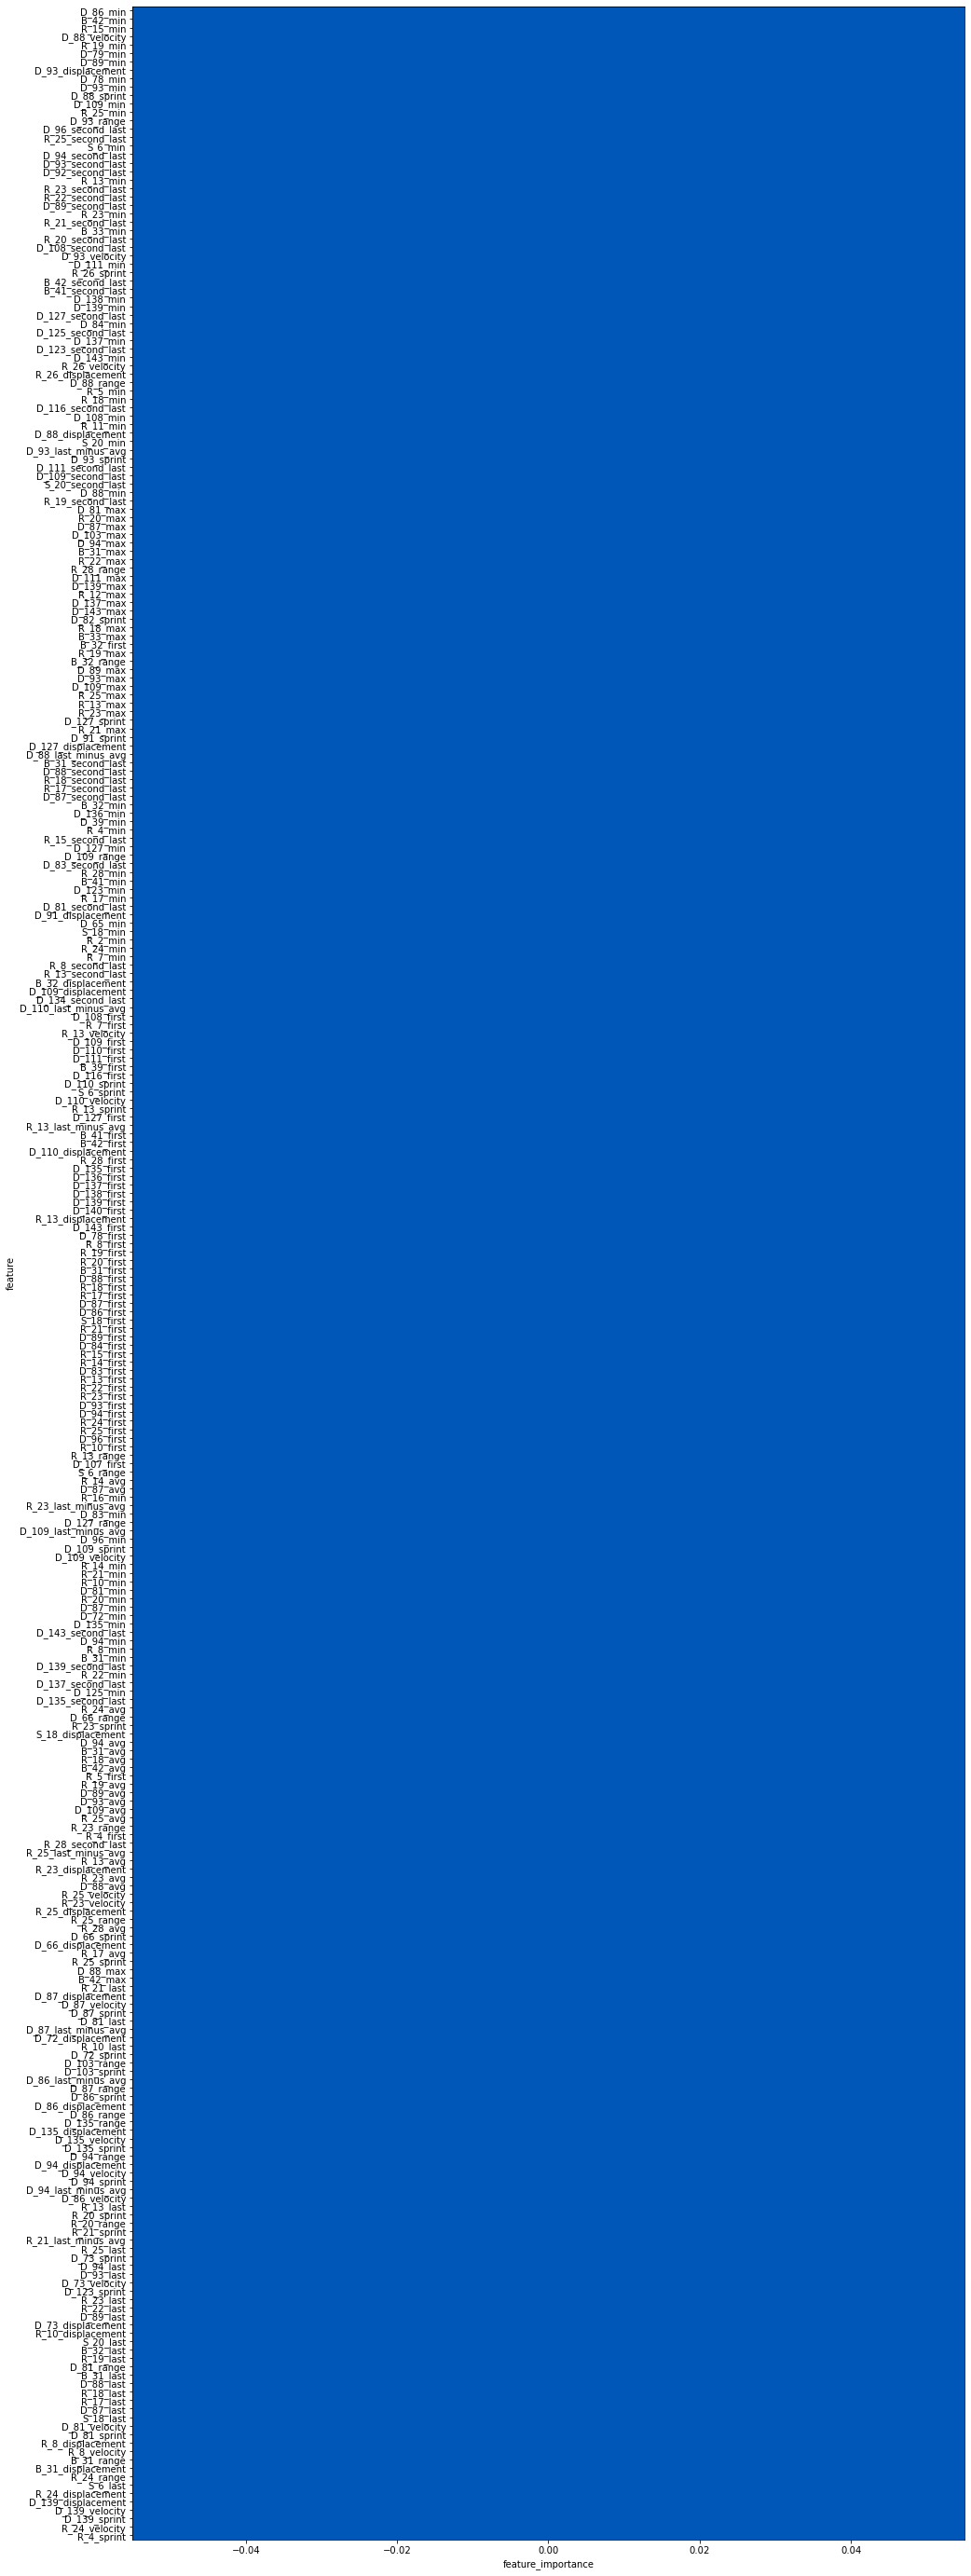

In [59]:
imp_df = plot_feature_importance(model.feature_name_, model.feature_importances_, figsize=(16, 50), ascending=True, limit=300)

In [62]:
imp_df.loc[imp_df["feature"] == "dummy"]

,feature,feature_importance
1657,dummy,149


In [75]:
zero_imp_features = sorted(imp_df.loc[imp_df["feature_importance"] == 0]["feature"].values.tolist())

In [78]:
pd.Series(zero_imp_features, name="feature").to_csv(f"{DROP_FEATURES_PATH}/noob_features.csv", index=False)

In [27]:
# train["target"] = target
# train.to_pickle(f"{EXP_PATH}/lgbm_gbdt_exp2/train_val.pkl")
# joblib.dump(train_score_list, f'{EXP_PATH}/lgbm_gbdt_exp2/5_fold_train_scores.pkl')
# joblib.dump(val_score_list, f'{EXP_PATH}/lgbm_gbdt_exp2/5_fold_val_scores.pkl')
# joblib.dump(val_idx_list, f'{EXP_PATH}/lgbm_gbdt_exp2/5_fold_val_indices.pkl')

### Tune LGBM using Optuna (Single)

In [ ]:
# def objective(trial):
#     params = {
#         "objective": "binary",
#         "verbosity": -1,
#         "boosting_type": "gbdt",
#         "random_state": 1,
#         "reg_alpha": trial.suggest_float("reg_alpha", 0.001, 0.1, log=True),
#         "reg_lambda": trial.suggest_float("reg_lambda", 15, 30, log=True),
#         "learning_rate": trial.suggest_float("learning_rate", 0.015, 0.03, log=True),
#         "n_estimators": trial.suggest_categorical("n_estimators", [1500, 1600, 1700, 1800, 1900, 2000]),
#         "colsample_bytree": trial.suggest_categorical("colsample_bytree", np.arange(0.15, 0.4, 0.01)),
#         "subsample": trial.suggest_categorical("subsample", np.arange(0.6, 0.8, 0.02)),
#         "subsample_freq": trial.suggest_categorical("subsample_freq", np.arange(2, 10, 1)),
#         "min_child_samples": trial.suggest_categorical("min_child_samples", [2000, 2250, 2500]),
#         "scale_pos_weight": trial.suggest_categorical("scale_pos_weight", np.arange(1.25, 2.5, 0.05)),
#         "max_bins": trial.suggest_categorical("max_bins", np.arange(400, 550, 25)),
#         "num_leaves": trial.suggest_categorical("num_leaves", np.arange(70, 180, 10)),
#     }
#     print(params)
#     X_train, X_val, y_train, y_val = train_test_split(train_agg, target, test_size=0.2)
#     model = LGBMClassifier(**params)
#     with warnings.catch_warnings():
#         warnings.filterwarnings('ignore', category=UserWarning)
#         model.fit(
#             X_train,
#             y_train,
#             eval_set=[(X_val, y_val)], 
#             verbose=0
#             # eval_metric=[lgb_amex_metric],
#             # callbacks=[log_evaluation(200)]
#         )
#     y_train_pred = model.predict_proba(X_train, raw_score=True)
#     train_score = amex_metric(y_train, y_train_pred)
#     y_val_pred = model.predict_proba(X_val, raw_score=True)
#     val_score = amex_metric(y_val, y_val_pred)
#     print(f"Fold {fold} | Train Score = {train_score:.5f}")
#     print(f"{Fore.GREEN}{Style.BRIGHT}Fold {fold} | Val   Score = {val_score:.5f}{Style.RESET_ALL}")
#     return val_score

In [ ]:
# study = optuna.create_study(direction="maximize")

In [ ]:
# study.optimize(objective, n_trials=35)

### Tune LGBM using Optuna (KFold)

In [31]:
def objective(trial):
    kf = StratifiedKFold(n_splits=5)
    params = {
        "objective": "binary",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "random_state": 1,
        "reg_alpha": trial.suggest_float("reg_alpha", 0.001, 0.1, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 15, 30, log=True),
        "learning_rate": trial.suggest_float("learning_rate", 0.015, 0.03, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 1700, 2100),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 0.4),
        "subsample": trial.suggest_float("subsample", 0.65, 0.75),
        "subsample_freq": trial.suggest_int("subsample_freq", 2, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 2000, 2500),
        "scale_pos_weight": trial.suggest_float("scale_pos_weight", 1.3, 2),
        "max_bins": trial.suggest_int("max_bins", 450, 550),
        "num_leaves": trial.suggest_int("num_leaves", 80, 160),
    }
    print(params)
    score_list = []
    for fold, (idx_tr, idx_va) in zip(range(1, 5+1), kf.split(train_agg, target)):
        X_train, X_val, y_train, y_val, model = None, None, None, None, None
        X_train = train_agg.iloc[idx_tr]
        X_val = train_agg.iloc[idx_va]
        y_train = target[idx_tr]
        y_val = target[idx_va]
        model = LGBMClassifier(**params)
        with warnings.catch_warnings():
            warnings.filterwarnings('ignore', category=UserWarning)
            model.fit(
                X_train,
                y_train,
                eval_set=[(X_val, y_val)], 
                verbose=0
                # eval_metric=[lgb_amex_metric],
                # callbacks=[log_evaluation(200)]
            )
        y_train_pred = model.predict_proba(X_train, raw_score=True)
        train_score = amex_metric(y_train, y_train_pred)
        X_train, y_train = None, None
        y_val_pred = model.predict_proba(X_val, raw_score=True)
        # joblib.dump(model, f'{MODELS_PATH}/0712/model_{idx+1}.pkl')
        val_score = amex_metric(y_val, y_val_pred)
        print(f"Fold {fold} | Train Score = {train_score:.5f}")
        print(f"{Fore.GREEN}{Style.BRIGHT}Fold {fold} | Val   Score = {val_score:.5f}{Style.RESET_ALL}")
        score_list.append(val_score)
    
    return np.mean(score_list)

In [32]:
study = optuna.create_study(direction="maximize")

[I 2022-07-15 10:29:26,446] A new study created in memory with name: no-name-088c96ba-9322-4f39-8711-ff24a584f78c


In [33]:
study.optimize(objective, n_trials=20)

{'objective': 'binary', 'verbosity': -1, 'boosting_type': 'gbdt', 'random_state': 1, 'reg_alpha': 0.004134572633611228, 'reg_lambda': 21.798633190143466, 'learning_rate': 0.02076640748977127, 'n_estimators': 1931, 'colsample_bytree': 0.3524191728037472, 'subsample': 0.7066280245777821, 'subsample_freq': 4, 'min_child_samples': 2204, 'scale_pos_weight': 1.3139922133338706, 'max_bins': 491, 'num_leaves': 130}


[W 2022-07-15 10:41:26,046] Trial 0 failed because of the following error: TypeError('unsupported format string passed to tuple.__format__')
Traceback (most recent call last):
  File "/Users/wklee/miniconda3/envs/amex/lib/python3.10/site-packages/optuna/study/_optimize.py", line 213, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/rx/900hbpv51bsg7d73m0zmd11m0000gn/T/ipykernel_6494/2010801601.py", line 45, in objective
    print(f"Fold {fold} | Train Score = {train_score:.5f}")
TypeError: unsupported format string passed to tuple.__format__


TypeError: unsupported format string passed to tuple.__format__

### END

In [ ]:
# study_df = study.trials_dataframe()
# study_df = study_df.loc[study_df["state"] == "COMPLETE"].reset_index(drop=True)
# study_df.to_csv(f"{EXP_PATH}/lgbm_dart_exp/t.csv", index=False)

In [ ]:
np.mean(val_score_list)

In [ ]:
%%time
model_list, score_list, y_pred_list, held_out_index_list = [], [], [], []
model_dict = {}
X_val_dict = {}
y_val_dict = {}
y_score_dict = {}
kf = StratifiedKFold(n_splits=10)
for fold, (idx_tr, idx_va), n_est in zip(range(1, 10+1), kf.split(train, target), n_est_list):
    model_dict[fold] = joblib.load(f"{MODELS_PATH}/lgbm_models/model_{fold}.pkl")
    X_val_dict[fold] = train.iloc[idx_va][features]
    y_val_dict[fold] = target[idx_va]
    y_score_dict[fold] = model_dict[fold].predict_proba(X_val_dict[fold], raw_score=True)

In [ ]:
for i in range(1, 11):
    print(i, amex_metric_np(y_score_dict[i], y_val_dict[i]))

In [ ]:
full_train = pd.concat(list(X_val_dict.values()))
full_train.shape

In [ ]:
full_train_gt = np.concatenate(list(y_val_dict.values()))
len(full_train_gt)

In [ ]:
full_train_scores = np.concatenate(list(y_score_dict.values()))
len(full_train_scores)

In [ ]:
full_train.loc[:, "target"] = full_train_gt
full_train.loc[:, "score"] = full_train_scores

In [ ]:
# full_train.to_csv(f"{EVALUATION_DATA_PATH}/train_single_raw_score.csv", index=False)

In [ ]:
full_train

In [ ]:
%%time
model_list, score_list, y_pred_list, held_out_index_list = [], [], [], []
kf = StratifiedKFold(n_splits=10)
for fold, (idx_tr, idx_va), n_est in zip(range(1, 10+1), kf.split(train, target), n_est_list):
    X_train, X_val, y_train, y_val, model = None, None, None, None, None
    start_time = datetime.datetime.now()
    X_train = train.iloc[idx_tr][features]
    X_val = train.iloc[idx_va][features]
    y_train = target[idx_tr]
    y_val = target[idx_va]
    
    model = my_booster(n_estimators=n_est)
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore', category=UserWarning)
        model.fit(X_train, 
                  y_train,
                  eval_set=[(X_val, y_val)], 
                  eval_metric=[lgb_amex_metric],
                  callbacks=[log_evaluation(200)])
    X_train, y_train = None, None
    y_val_pred = model.predict_proba(X_val, raw_score=True)
    score = amex_metric(y_val, y_val_pred)
    n_trees = model.best_iteration_
    if n_trees is None: 
        n_trees = model.n_estimators
    print(f"{Fore.GREEN}{Style.BRIGHT}Fold {fold} | {str(datetime.datetime.now() - start_time)[-12:-7]} |"
          f" {n_trees:5} trees |"
          f"                Score = {score:.5f}{Style.RESET_ALL}")
    score_list.append(score)
    model_list.append(model)
    held_out_index_list.append(idx_va)
    # if INFERENCE:
    #     y_pred_list.append(model.predict_proba(test[features], raw_score=True))
        
    # if ONLY_FIRST_FOLD:
    #     break # we only want the first fold
    
print(f"{Fore.GREEN}{Style.BRIGHT}OOF Score:                       {np.mean(score_list):.5f}{Style.RESET_ALL}")

In [ ]:
for idx, model in enumerate(model_list):
    joblib.dump(model, f'../models/lgbm_models/model_{idx+1}.pkl')

### Test Metric

In [ ]:
y_val_df = pd.DataFrame(y_val).reset_index(drop=True)
y_val_pred_df = pd.DataFrame(y_val_pred).rename(columns={0: "prediction"})

In [ ]:
amex_metric(y_val_df, y_val_pred_df)

In [ ]:
# feature_imp_thr = imp_df.loc[imp_df["feature"] == "dummy"]["feature_importance"].values[0]
# feature_imp_thr

In [ ]:
selected_features = imp_df.loc[imp_df["feature_importance"] > 0]["feature"].tolist()
len(selected_features)

In [ ]:
y_train_pred = final_lgbm_clf.predict_proba(X_train)[:, 1]
y_val_pred = final_lgbm_clf.predict_proba(X_val)[:, 1]

In [ ]:
plot_roc_curves([y_train, y_val], 
                [y_train_pred, y_val_pred], 
                labels=["Train", "Validation"], 
                title="Train Validation ROC AUC")

In [ ]:
imp_df = plot_feature_importance(final_lgbm_clf.feature_name_, 
                                 final_lgbm_clf.feature_importances_, 
                                 title="Feature Importance",
                                 limit=50)

In [ ]:
selected_features = imp_df.loc[imp_df["feature_importance"] > 0]["feature"].tolist()
len(selected_features)

#### Final x2 LGBM

In [ ]:
selected_features = [col for col in selected_features if "first" not in col]
len(selected_features)

In [ ]:
final_lgbm_clf = LGBMClassifier(**best_params)

In [ ]:
X_train_ = X_train.loc[:, selected_features]
X_val_ = X_val.loc[:, selected_features]

In [ ]:
final_lgbm_clf.fit(X_train_, y_train)

In [ ]:
y_train_pred_ = final_lgbm_clf.predict_proba(X_train_)[:, 1]
y_val_pred_ = final_lgbm_clf.predict_proba(X_val_)[:, 1]

In [ ]:
plot_roc_curves([y_train, y_val], 
                [y_train_pred_, y_val_pred_], 
                labels=["Train", "Validation"], 
                title="Train Validation ROC AUC")

In [ ]:
y_res_df = pd.DataFrame(y_res).reset_index(drop=True)
y_res_pred_df = pd.DataFrame(y_res_pred_).rename(columns={0: "prediction"})

In [ ]:
amex_metric(y_res_df, y_res_pred_df)

In [ ]:
y_val.values[:40]

In [ ]:
temp_ = [1 if c > 0.95 else c for c in y_val_pred_]
# temp_[:40]

In [ ]:
y_val_df = pd.DataFrame(y_val).reset_index(drop=True)
y_val_pred_df = pd.DataFrame(y_val_pred_).rename(columns={0: "prediction"})

In [ ]:
amex_metric(y_val_df, y_val_pred_df)

### END

### LGBM Error Analysis

In [ ]:
X_validation = X_val_.reset_index(drop=True)

In [ ]:
top4_pct_df, gini_df = get_final_metric_df(X_validation, y_val_df, y_val_pred_df)

In [ ]:
failed_top4_pct_indices = top4_pct_df.loc[(top4_pct_df["is_cutoff"] == 1) & (top4_pct_df["target"] == 0)].index

In [ ]:
# failed_top4_pct_indices

In [ ]:
failed_top4_pct_indices

In [ ]:
success_top4 = top4_pct_df.loc[~top4_pct_df.index.isin(failed_top4_pct_indices)]
failed_top4 = top4_pct_df.loc[failed_top4_pct_indices]

In [ ]:
success_top4.shape, failed_top4.shape

In [ ]:
column = "P_2_last"

In [ ]:
top4_pct_df.groupby("target")[column].mean()

In [ ]:
success_top4[column].describe()

In [ ]:
failed_top4[column].describe()

In [ ]:
# save model
# joblib.dump(final_lgbm_clf, '../models/lgbm_version1.pkl')

In [ ]:
# load model
loaded_lgbm_model = joblib.load('../models/lgbm_version1.pkl')

### Linear Analysis

In [ ]:
array = train_data.loc[train_data["customer_ID"] == train_data["customer_ID"][540]]["P_2"].astype("float32")

In [ ]:
np.polyfit(x=range(len(array)), y=array, deg=1)

In [ ]:
def calc_grad(array):
    if len(array) >= 2:
        gradient, y_intercept = np.polyfit(x=range(len(array)), y=array.astype("float32"), deg=1)
        return gradient
    else:
        return 0

In [ ]:
def calc_intercept(array):
    if len(array) >= 2:
        gradient, y_intercept = np.polyfit(x=range(len(array)), y=array.astype("float32"), deg=1)
        return y_intercept
    else:
        return array.values[0]

In [ ]:
temp = train.groupby("customer_ID").agg(P_2_grad=("P_2", calc_grad),
                                        P_2_intercept=("P_2", calc_intercept)).reset_index()
train_agg_summary = train_agg_summary.merge(temp, on="customer_ID", how="left")

In [ ]:
temp = test.groupby("customer_ID").agg(P_2_grad=("P_2", calc_grad),
                                       P_2_intercept=("P_2", calc_intercept)).reset_index()
test_agg_summary = test_agg_summary.merge(temp, on="customer_ID", how="left")